## 任务 B ：三个数据集的本地搜索引擎

## B.1 家具杂志数据集（文本-图像）

#### 数据预处理（构建映射关系）

In [63]:
import os
import fitz  # PyMuPDF
from PIL import Image
from tqdm import tqdm
import json

def extract_text_image_pairs(pdf_folder, output_image_folder, output_json="text_image_mapping.json"):
    os.makedirs(output_image_folder, exist_ok=True)
    result = []
    idx = 0

    for file_name in tqdm(os.listdir(pdf_folder)):
        if not file_name.endswith(".pdf"):
            continue
        pdf_path = os.path.join(pdf_folder, file_name)
        doc = fitz.open(pdf_path)
        for page_number in range(len(doc)):
            page = doc.load_page(page_number)
            text = page.get_text().strip()
            if not text:
                continue  # 跳过没有文本的页面

            # 将整个页面截图保存为图像
            pix = page.get_pixmap(dpi=200)
            image_path = os.path.join(output_image_folder, f"{os.path.splitext(file_name)[0]}_page_{page_number + 1}.png")
            pix.save(image_path)

            result.append({
                "text": text,
                "image_path": image_path
            })
            idx += 1
            if page_number == 15: # 为节省时间，只取前 n 张进行训练
                break

    # 保存 JSON 映射
    with open(output_json, "w", encoding="utf-8") as f:
        json.dump(result, f, ensure_ascii=False, indent=2)
    
    print(f"共提取 {idx} 个文本-图像对，已保存至 {output_json}")
    return result

extract_text_image_pairs(
    pdf_folder="ori_data/The_combination_of_images_and_text",
    output_image_folder="mid2_data/dataset1/extracted_images",
    output_json="mid2_data/dataset1/text_image_mapping.json"
)


100%|██████████| 20/20 [02:02<00:00,  6.14s/it]

共提取 301 个文本-图像对，已保存至 mid2_data/dataset1/text_image_mapping.json


[{'text': '2 0 2 2\nL I V I N G  P R O D U C T S',
  'image_path': 'mid2_data/dataset1/extracted_images/Living_Products_2022_page_1.png'},
 {'text': 'Living Products\n2022\ncassina.com',
  'image_path': 'mid2_data/dataset1/extracted_images/Living_Products_2022_page_2.png'},
 {'text': '3 Fauteuil Grand Confort, \ngrand modèle, trois places, \ndurable\nLe Corbusier, P. Jeanneret, \nC. Perriand\n3 Fauteuil Grand Confort, \nméridienne, durable\nLe Corbusier, P. Jeanneret, \nC. Perriand\n4 Chaise longue à réglage \ncontinu\nLe Corbusier, P. Jeanneret, \nC. Perriand\n4 Chaise longue à réglage \ncontinu, noire\nLe Corbusier, P. Jeanneret, \nC. Perriand\nLady\nMarco Zanuso\nOmbra\nCharlotte Perriand\nP22\nPatrick Norguet\nSoriana\nAfra & Tobia Scarpa\nSoriana\nAfra & Tobia Scarpa\nTokyo Chaise Longue\nCharlotte Perriand\nTokyo Dormeuse\nCharlotte Perriand\nTre pezzi\nFranco Albini\nUtrecht\nGerrit Thomas Rietveld\nUtrecht Baby/XL\nGerrit Thomas Rietveld\nWink\nToshiyuki Kita\nWoodline\nMarco Z

#### 向量化数据

In [64]:
# vectorize_dataset1.py

import json
from PIL import Image
import torch
from torchvision import transforms
from transformers import BertTokenizer, BertModel
from torchvision.models import resnet18
import os

# 加载 BERT 和 ResNet 模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

resnet = resnet18(pretrained=True)
resnet.fc = torch.nn.Identity()  # 去掉最后的分类层
resnet = resnet.to(device).eval()

# 图像预处理
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def vectorize_text(text):
    inputs = bert_tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze(0).cpu().numpy()  # 使用平均池化

def vectorize_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = img_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = resnet(image).squeeze(0).cpu().numpy()
    return features

def build_vector_dataset(json_path, save_path):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    vector_data = []
    for item in tqdm(data):
        text_vec = vectorize_text(item["text"])
        img_vec = vectorize_image(item["image_path"])
        vector_data.append({
            "text": item["text"],
            "image_path": item["image_path"],
            "text_vec": text_vec.tolist(),
            "img_vec": img_vec.tolist()
        })

    with open(save_path, "w", encoding="utf-8") as f:
        json.dump(vector_data, f, ensure_ascii=False, indent=2)
    print(f"已保存向量化数据到 {save_path}")

# 示例运行
build_vector_dataset(
    json_path="mid2_data/dataset1/text_image_mapping.json",
    save_path="mid2_data/dataset1/vectorized.json"
)


/home/fintuser/fintechlab/dev/condaEnvs/z_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fintuser/fintechlab/dev/condaEnvs/z_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 301/301 [00:34<00:00,  8.63it/s]


已保存向量化数据到 mid2_data/dataset1/vectorized.json


#### SOM实现

In [65]:
import os
import json
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

class SOM:
    def __init__(self, m, n, dim, num_iterations=100, alpha0=0.5, sigma0=None):
        """
        m, n: SOM 网格尺寸
        dim: 输入向量维度
        num_iterations: 训练迭代次数
        alpha0: 初始学习率
        sigma0: 初始邻域半径，默认为 max(m,n)/2
        """
        self.m, self.n, self.dim = m, n, dim
        self.num_iterations = num_iterations
        self.alpha0 = alpha0
        self.sigma0 = sigma0 if sigma0 is not None else max(m, n) / 2.0
        
        # 随机初始化权重
        self.weights = np.random.randn(m, n, dim)

        self.qe_history = []  # 每个 epoch 的 QE
        self.te_history = []  # 每个 epoch 的 TE
        
    def _decay(self, t):
        """随迭代 t 衰减学习率和半径"""
        alpha = self.alpha0 * (1 - t / self.num_iterations)
        sigma = self.sigma0 * (1 - t / self.num_iterations)
        return alpha, sigma
    
    def _find_bmu(self, x):
        """找到 Best Matching Unit 的网格坐标 (i, j)"""
        # 计算 x 与每个权重的欧氏距离
        dists = np.linalg.norm(self.weights - x.reshape(1, 1, -1), axis=2)
        return np.unravel_index(np.argmin(dists), (self.m, self.n))

    def quantization_error(self, data):
        """QE = 样本到其 BMU 权重向量的平均欧氏距离"""
        # data: (N, dim), weights_flat: (M, dim)，M = m*n
        weights_flat = self.weights.reshape(-1, self.dim)  # (M, dim)
        # 广播计算距离 (N, M)
        dists = np.linalg.norm(data[:, None, :] - weights_flat[None, :, :], axis=2)
        # 对每个样本取最小距离，再平均
        qe = np.mean(np.min(dists, axis=1))
        return float(qe)
    
    def topographic_error(self, data):
        """TE = 第一和第二 BMU 不相邻的样本占比"""
        weights_flat = self.weights.reshape(-1, self.dim)  # (M, dim)
        dists = np.linalg.norm(data[:, None, :] - weights_flat[None, :, :], axis=2)  # (N, M)
        # 前两个最小的索引
        idx_smallest = np.argpartition(dists, 2, axis=1)[:, :2]  # (N, 2)
        # 解码到 (i, j)
        coords = np.array([divmod(idx, self.n) for idx in range(self.m*self.n)])
        bmu1 = coords[idx_smallest[:, 0]]  # (N, 2)
        bmu2 = coords[idx_smallest[:, 1]]
        manh_dist = np.abs(bmu1 - bmu2).sum(axis=1)
        # 不相邻的比例
        te = np.mean(manh_dist > 1)
        return float(te)

    
    def train(self, data):
        """
        data: (num_samples, dim) numpy array
        """
        for t in range(self.num_iterations):

            alpha, sigma = self._decay(t)
            for x in data:
                i_bmu, j_bmu = self._find_bmu(x)
                # 更新 BMU 及其邻居
                for i in range(self.m):
                    for j in range(self.n):
                        # 网格上 (i,j) 到 BMU 的距离
                        dist_grid = np.linalg.norm(np.array([i, j]) - np.array([i_bmu, j_bmu]))
                        # 邻域函数：高斯
                        h = np.exp(- (dist_grid**2) / (2 * (sigma**2)))
                        # 权重更新
                        self.weights[i, j] += alpha * h * (x - self.weights[i, j])
            # 每次迭代之后记录qe和te
            self.qe_history.append(self.quantization_error(data))
            self.te_history.append(self.topographic_error(data))

        print(f"SOM training complete ({self.m}×{self.n}, {self.num_iterations} iter)")

    def plot_errors(self):
        # QE 曲线
        plt.figure()
        plt.plot(range(1, self.num_iterations+1), self.qe_history)
        plt.title("Quantization Error over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("QE")
        plt.show()

        # TE 曲线
        plt.figure()
        plt.plot(range(1, self.num_iterations+1), self.te_history)
        plt.title("Topographic Error over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("TE")
        plt.show()

    
    def map_vector(self, x):
        """返回向量 x 在网格中的 BMU 坐标"""
        return self._find_bmu(x)
    
    def map_data(self, data):
        """批量映射：返回每个样本的 BMU 坐标列表"""
        return np.array([self._find_bmu(x) for x in data])

def load_vectorized(path):
    """加载 vectorized.json"""
    with open(path, "r", encoding="utf-8") as f:
        items = json.load(f)
    text_vecs = np.array([np.array(it["text_vec"]) for it in items])
    img_vecs  = np.array([np.array(it["img_vec"]) for it in items])
    return items, text_vecs, img_vecs

def train_som_on(vecs, som_dim=(10,10), iterations=100):
    """对 vecs 先标准化再训练 SOM，返回 (som, scaler)"""
    scaler = StandardScaler()
    vs = scaler.fit_transform(vecs)
    som = SOM(som_dim[0], som_dim[1], vs.shape[1], num_iterations=iterations)
    som.train(vs)
    return som, scaler

def search_by_text(query, items, text_som, text_scaler, top_k, max_radius):
    """
    改进版搜索：
    1) 先找同 BMU 的样本
    2) 若为空，依次扩大到邻近格点（半径 1,2,...）
    3) 若仍为空，退回全局余弦相似度搜索
    """
    # 1. 向量化 & 标准化
    q_vec = vectorize_text(query)
    q_vec_scaled = text_scaler.transform([q_vec])[0]
    bmu = text_som.map_vector(q_vec_scaled)
    
    # 2. 收集同格点及邻近格点候选
    candidates = []
    # 生成所有可能的 (i,j) 在 radius 内
    for r in range(0, max_radius+1):
        # 当 r=0 时，只检查同格点；r>0 时扩散
        for di in range(-r, r+1):
            for dj in range(-r, r+1):
                if abs(di) + abs(dj) > r:  # 保持曼哈顿距离 r
                    continue
                ni, nj = bmu[0] + di, bmu[1] + dj
                if not (0 <= ni < text_som.m and 0 <= nj < text_som.n):
                    continue
                # 收集落在 (ni,nj) 上的样本
                for it in items:
                    tv = np.array(it["text_vec"])
                    tv_scaled = text_scaler.transform([tv])[0]
                    if text_som.map_vector(tv_scaled) == (ni, nj):
                        sim = cosine_similarity([q_vec], [tv])[0][0]
                        candidates.append((it["image_path"], sim))
        if candidates:
            break  # 找到即停止扩散
    
    # 3. 回退全局余弦相似度
    if not candidates:
        print("⚠️ 同格点及邻近格点均无候选，退回全局搜索")
        sims = cosine_similarity(
            [q_vec], 
            [np.array(it["text_vec"]) for it in items]
        )[0]
        candidates = [(items[i]["image_path"], sims[i]) for i in range(len(items))]
    
    # 4. 排序 & 返回
    candidates = list({path:score for path,score in candidates}.items())  # 去重
    candidates.sort(key=lambda x: -x[1])
    return candidates[:top_k]

#### 主成分RGB绘制

In [66]:
from sklearn.decomposition import PCA

def plot_som_pca_rgb(som, data=None, mode="som-only"):
    """
    使用 PCA 将 SOM 节点的权重映射为 RGB 图像。
    
    参数:
        som: SOM 实例
        data: 可选，用于 global 模式的训练数据（标准化后的）
        mode: "som-only" or "global"
    """
    assert mode in ["som-only", "global"], "mode 必须为 'som-only' 或 'global'"
    
    weights = som.weights.reshape(-1, som.dim)  # (m*n, dim)

    if mode == "som-only":
        pca = PCA(n_components=3)
        rgb_vals = pca.fit_transform(weights)
    elif mode == "global":
        if data is None:
            raise ValueError("global 模式需要提供标准化后的训练数据")
        pca = PCA(n_components=3)
        pca.fit(data)
        rgb_vals = pca.transform(weights)

    # 归一化为 0~1
    rgb_vals = (rgb_vals - rgb_vals.min(0)) / (rgb_vals.max(0) - rgb_vals.min(0) + 1e-8)
    rgb_image = rgb_vals.reshape(som.m, som.n, 3)

    # 绘图
    plt.figure(figsize=(6, 6))
    plt.imshow(rgb_image)
    plt.title(f"SOM PCA RGB Visualization ({mode})")
    plt.axis("off")
    plt.show()


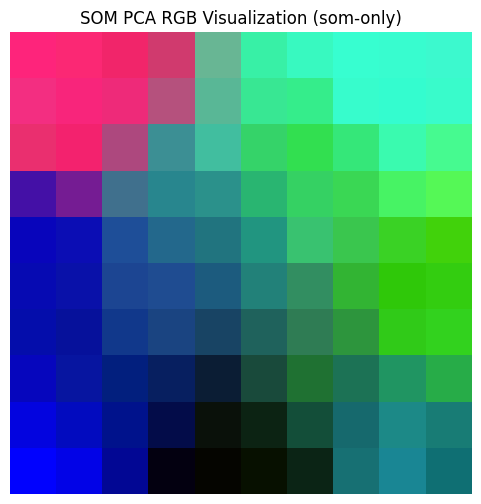

In [69]:
# 使用 SOM-only 模式可视化
plot_som_pca_rgb(som, mode="som-only")

#### 展示图像对应文本（方便之后划定搜索）

In [70]:
# 1. 加载向量数据
items, text_vecs, img_vecs = load_vectorized("mid2_data/dataset1/vectorized.json")

In [71]:
def preview_image_text(items, num=10):
    """
    打印前 num 个样本的 图像路径 + 对应文本
    """
    print(f"预览前 {num} 个图像-文本对：")
    for i, it in enumerate(items[:num], start=1):
        print(f"{i:2d}. 图像: {it['image_path']}")
        # print(f"    文本: {it['text'][:]}")
        print(f"    文本: {it['text'][:80].replace('\n',' ')}{'...' if len(it['text'])>80 else ''}")
        print('*-'*50)

    print("-" * 50)

# 1. 预览前10个图像-文本对
preview_image_text(items, num=10)

预览前 10 个图像-文本对：
 1. 图像: mid2_data/dataset1/extracted_images/Living_Products_2022_page_1.png
    文本: 2 0 2 2 L I V I N G  P R O D U C T S
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
 2. 图像: mid2_data/dataset1/extracted_images/Living_Products_2022_page_2.png
    文本: Living Products 2022 cassina.com
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
 3. 图像: mid2_data/dataset1/extracted_images/Living_Products_2022_page_3.png
    文本: 3 Fauteuil Grand Confort,  grand modèle, trois places,  durable Le Corbusier, P....
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
 4. 图像: mid2_data/dataset1/extracted_images/Living_Products_2022_page_4.png
    文本: Collection Chandigarh Colourdisc Home Fragrances LC17 Portemanteau,  Unités de C...
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
 5. 图像

#### 训练 SOM

In [72]:
# 3. 训练文本 SOM
text_som, text_scaler = train_som_on(text_vecs, som_dim=(10,10), iterations=100)

# （可选）训练图像 SOM，用于后续扩展
# img_som, img_scaler = train_som_on(img_vecs, som_dim=(10,10), iterations=100)

SOM training complete (10×10, 100 iter)


#### 搜索测试

In [73]:
# 4. 搜索测试
query = "Colourdisc Home Fragrances LC17 Portemanteau, "

results = search_by_text(
    "请找与清朝历史有关的页面",
    items, text_som, text_scaler,
    top_k=5,    # 最多返回 5 张图
    max_radius=2  # 最多搜索到曼哈顿距离为 2 的格点
)

print("搜索结果（图像路径, 相似度）：")
for path, score in results:
    print(f"{path} — {score:.4f}")

搜索结果（图像路径, 相似度）：
mid2_data/dataset1/extracted_images/09 - DETAILS COLLECTION 2024_page_4.png — 0.3280
mid2_data/dataset1/extracted_images/Cassina-LB-DETAILS_page_4.png — 0.3237
mid2_data/dataset1/extracted_images/cassina_yachting_lookbook_page_3.png — 0.2849


#### 绘制训练过程中的 QE 和 TE

SOM training complete (10×10, 100 iter)


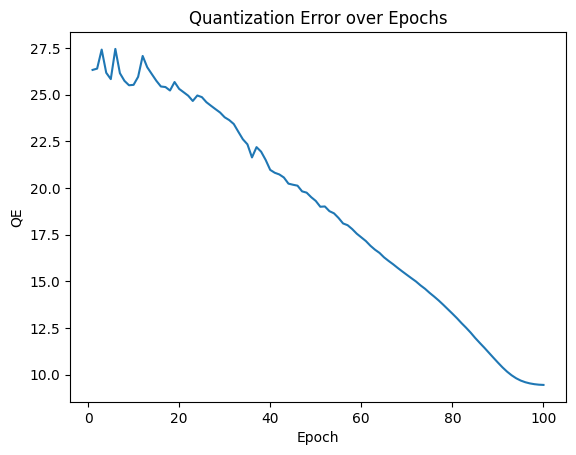

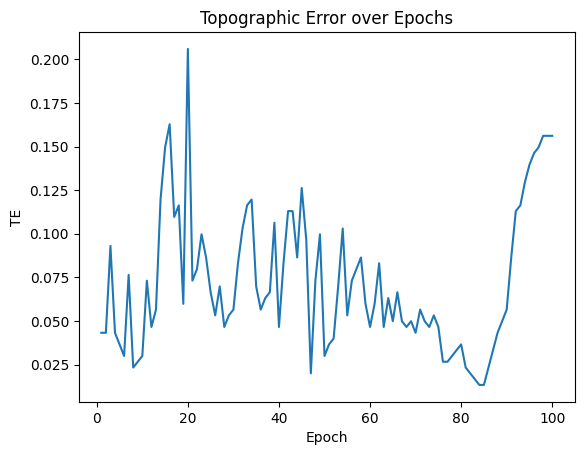

In [74]:
som, scaler = train_som_on(text_vecs, som_dim=(10,10), iterations=100)
som.plot_errors()

## B.2 论文数据集（纯文本任务）

#### 数据预处理

In [75]:
# ## 数据预处理：提取纯文本数据集（text, title）
import os
import re
import json
import fitz   # PyMuPDF
from tqdm import tqdm

def extract_text_title_pairs(
    pdf_folder: str,
    output_json: str,
    raw_text_dir: str = None
):
    """
    从 pdf_folder 中读取所有 .pdf，提取全文 text 和清洗后的 title，
    并保存到 output_json；如果 raw_text_dir 不为 None，则同时把每篇文档
    的纯文本写入 raw_text_dir 下的 .txt 文件。
    """
    os.makedirs(os.path.dirname(output_json), exist_ok=True)
    if raw_text_dir:
        os.makedirs(raw_text_dir, exist_ok=True)

    mapping = []
    for fname in tqdm(os.listdir(pdf_folder), desc="Processing PDFs"):
        if not fname.lower().endswith(".pdf"):
            continue
        path = os.path.join(pdf_folder, fname)

        # 1) 清洗标题：去掉开头数字和分隔符
        base = os.path.splitext(fname)[0]
        # 去掉开头的“数字 + 分隔符”模式，例如 "01-My Title" 或 "001_My Title"
        title = re.sub(r'^\s*\d+[\-\._\s]*', '', base).strip()

        # 2) 提取全文
        doc = fitz.open(path)
        full_text = []
        for page in doc:
            txt = page.get_text().strip()
            if txt:
                full_text.append(txt)
        text = "\n\n".join(full_text)
        doc.close()

        # 3) 如果需要，保存为 .txt 文件
        if raw_text_dir:
            safe_name = re.sub(r'[^\w\-]', '_', base)  # 文件名合法化
            txt_path = os.path.join(raw_text_dir, f"{safe_name}.txt")
            with open(txt_path, "w", encoding="utf-8") as f:
                f.write(text)

        mapping.append({
            "title": title,
            "text": text
        })

    # 4) 保存 JSON 映射
    with open(output_json, "w", encoding="utf-8") as f:
        json.dump(mapping, f, ensure_ascii=False, indent=2)

    print(f"➡️ 共处理 {len(mapping)} 篇文档，已保存映射到 {output_json}")
    return mapping

# 调用示例
mapping = extract_text_title_pairs(
    pdf_folder="ori_data/The_Journals_of_title_and_text",
    output_json="mid2_data/dataset2/text_title_mapping.json",
    raw_text_dir="mid2_data/dataset2/raw_texts"
)


Processing PDFs: 100%|██████████| 40/40 [00:07<00:00,  5.49it/s]

➡️ 共处理 40 篇文档，已保存映射到 mid2_data/dataset2/text_title_mapping.json


#### 文本向量化

In [76]:
# ## vectorize_dataset2_chunked.py

import os
import json
import torch
import numpy as np
from tqdm import tqdm
from transformers import BertTokenizer, BertModel

# 1. 设备和模型初始化
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased").to(device)
model.eval()

def vectorize_text_chunked(text: str, max_length: int = 512) -> np.ndarray:
    """
    对超长文本进行分块（chunk），每块长度不超过 max_length-2 的 token，
    每块加 [CLS] 和 [SEP]，padding 到 max_length，分别编码、pooling，
    最后对所有块的 embedding 做平均。
    """
    # 1. 用 tokenizer 得到所有 token id（不添加 special tokens）
    all_tokens = tokenizer.encode(text, add_special_tokens=False)
    chunk_size = max_length - 2  # 留出 [CLS] 和 [SEP]
    embeddings = []

    # 2. 分块编码
    for i in range(0, len(all_tokens), chunk_size):
        chunk_tokens = all_tokens[i : i + chunk_size]
        # 添加 special tokens
        input_ids = [tokenizer.cls_token_id] + chunk_tokens + [tokenizer.sep_token_id]
        attention_mask = [1] * len(input_ids)

        # padding 到 max_length
        pad_len = max_length - len(input_ids)
        input_ids += [tokenizer.pad_token_id] * pad_len
        attention_mask += [0] * pad_len

        # 转 tensor 并送入模型
        input_ids_tensor = torch.tensor([input_ids], device=device)
        attention_mask_tensor = torch.tensor([attention_mask], device=device)
        with torch.no_grad():
            outputs = model(input_ids=input_ids_tensor, attention_mask=attention_mask_tensor)
        
        # mean pooling（排除 padding）
        last_hidden = outputs.last_hidden_state                # (1, seq_len, hidden)
        mask = attention_mask_tensor.unsqueeze(-1)             # (1, seq_len, 1)
        summed = (last_hidden * mask).sum(dim=1)               # (1, hidden)
        counts = mask.sum(dim=1)                               # (1, 1)
        embedding = (summed / counts).squeeze(0).cpu().numpy() # (hidden,)
        embeddings.append(embedding)

    # 3. 返回所有块 embedding 的平均
    return np.mean(embeddings, axis=0)


def build_vector_dataset2_chunked(
    input_json: str = "mid2_data/dataset2/text_title_mapping.json",
    output_json: str = "mid2_data/dataset2/vectorized_chunked.json"
):
    """
    读取 text_title_mapping.json，将每篇文章文本分块后向量化，
    保存为带 text_vec 的新 JSON 文件。
    """
    os.makedirs(os.path.dirname(output_json), exist_ok=True)

    with open(input_json, "r", encoding="utf-8") as f:
        records = json.load(f)

    vectorized = []
    for rec in tqdm(records, desc="Vectorizing long texts"):
        vec = vectorize_text_chunked(rec["text"])
        vectorized.append({
            "title":    rec["title"],
            "text":     rec["text"],
            "text_vec": vec.tolist()
        })

    with open(output_json, "w", encoding="utf-8") as f:
        json.dump(vectorized, f, ensure_ascii=False, indent=2)

    print(f"➡️ 已保存分块向量化数据到 {output_json}")


build_vector_dataset2_chunked()


Vectorizing long texts: 100%|██████████| 40/40 [00:34<00:00,  1.16it/s]

➡️ 已保存分块向量化数据到 mid2_data/dataset2/vectorized_chunked.json


#### SOM实现

In [77]:
import os
import json
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

class SOM:
    def __init__(self, m, n, dim, num_iterations=100, alpha0=0.5, sigma0=None):
        """
        m, n: SOM 网格尺寸
        dim: 输入向量维度
        num_iterations: 训练迭代次数
        alpha0: 初始学习率
        sigma0: 初始邻域半径，默认为 max(m,n)/2
        """
        self.m, self.n, self.dim = m, n, dim
        self.num_iterations = num_iterations
        self.alpha0 = alpha0
        self.sigma0 = sigma0 if sigma0 is not None else max(m, n) / 2.0
        
        # 随机初始化权重
        self.weights = np.random.randn(m, n, dim)

        self.qe_history = []  # 每个 epoch 的 QE
        self.te_history = []  # 每个 epoch 的 TE
        
    def _decay(self, t):
        """随迭代 t 衰减学习率和半径"""
        alpha = self.alpha0 * (1 - t / self.num_iterations)
        sigma = self.sigma0 * (1 - t / self.num_iterations)
        return alpha, sigma
    
    def _find_bmu(self, x):
        """找到 Best Matching Unit 的网格坐标 (i, j)"""
        # 计算 x 与每个权重的欧氏距离
        dists = np.linalg.norm(self.weights - x.reshape(1, 1, -1), axis=2)
        return np.unravel_index(np.argmin(dists), (self.m, self.n))

    def quantization_error(self, data):
        """QE = 样本到其 BMU 权重向量的平均欧氏距离"""
        # data: (N, dim), weights_flat: (M, dim)，M = m*n
        weights_flat = self.weights.reshape(-1, self.dim)  # (M, dim)
        # 广播计算距离 (N, M)
        dists = np.linalg.norm(data[:, None, :] - weights_flat[None, :, :], axis=2)
        # 对每个样本取最小距离，再平均
        qe = np.mean(np.min(dists, axis=1))
        return float(qe)
    
    def topographic_error(self, data):
        """TE = 第一和第二 BMU 不相邻的样本占比"""
        weights_flat = self.weights.reshape(-1, self.dim)  # (M, dim)
        dists = np.linalg.norm(data[:, None, :] - weights_flat[None, :, :], axis=2)  # (N, M)
        # 前两个最小的索引
        idx_smallest = np.argpartition(dists, 2, axis=1)[:, :2]  # (N, 2)
        # 解码到 (i, j)
        coords = np.array([divmod(idx, self.n) for idx in range(self.m*self.n)])
        bmu1 = coords[idx_smallest[:, 0]]  # (N, 2)
        bmu2 = coords[idx_smallest[:, 1]]
        manh_dist = np.abs(bmu1 - bmu2).sum(axis=1)
        # 不相邻的比例
        te = np.mean(manh_dist > 1)
        return float(te)

    
    def train(self, data):
        """
        data: (num_samples, dim) numpy array
        """
        for t in range(self.num_iterations):

            alpha, sigma = self._decay(t)
            for x in data:
                i_bmu, j_bmu = self._find_bmu(x)
                # 更新 BMU 及其邻居
                for i in range(self.m):
                    for j in range(self.n):
                        # 网格上 (i,j) 到 BMU 的距离
                        dist_grid = np.linalg.norm(np.array([i, j]) - np.array([i_bmu, j_bmu]))
                        # 邻域函数：高斯
                        h = np.exp(- (dist_grid**2) / (2 * (sigma**2)))
                        # 权重更新
                        self.weights[i, j] += alpha * h * (x - self.weights[i, j])
            # 每次迭代之后记录qe和te
            self.qe_history.append(self.quantization_error(data))
            self.te_history.append(self.topographic_error(data))

        print(f"SOM training complete ({self.m}×{self.n}, {self.num_iterations} iter)")

    def plot_errors(self):
        # QE 曲线
        plt.figure()
        plt.plot(range(1, self.num_iterations+1), self.qe_history)
        plt.title("Quantization Error over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("QE")
        plt.show()

        # TE 曲线
        plt.figure()
        plt.plot(range(1, self.num_iterations+1), self.te_history)
        plt.title("Topographic Error over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("TE")
        plt.show()

    
    def map_vector(self, x):
        """返回向量 x 在网格中的 BMU 坐标"""
        return self._find_bmu(x)
    
    def map_data(self, data):
        """批量映射：返回每个样本的 BMU 坐标列表"""
        return np.array([self._find_bmu(x) for x in data])

def load_vectorized(path):
    """加载 vectorized.json"""
    with open(path, "r", encoding="utf-8") as f:
        items = json.load(f)
    text_vecs = np.array([np.array(it["text_vec"]) for it in items])
    img_vecs  = np.array([np.array(it["img_vec"]) for it in items])
    return items, text_vecs, img_vecs

def train_som_on(vecs, som_dim=(10,10), iterations=100):
    """对 vecs 先标准化再训练 SOM，返回 (som, scaler)"""
    scaler = StandardScaler()
    vs = scaler.fit_transform(vecs)
    som = SOM(som_dim[0], som_dim[1], vs.shape[1], num_iterations=iterations)
    som.train(vs)
    return som, scaler


#### 加载数据并训练SOM网络

In [78]:
# —— 辅助函数 —— 
def load_text_vectors(path):
    """
    加载 mid2_data/dataset2/vectorized_chunked.json
    返回 titles, raw_texts, text_vecs(np.array)
    """
    with open(path, "r", encoding="utf-8") as f:
        records = json.load(f)
    titles   = [r["title"]    for r in records]
    texts    = [r["text"]     for r in records]
    vecs     = np.vstack([r["text_vec"] for r in records])
    return titles, texts, vecs
    
# 1. 加载向量
_, _, text_vecs = load_text_vectors("mid2_data/dataset2/vectorized_chunked.json")

In [79]:
# 2. 训练 SOM
som_text, scaler_text = train_som_on(text_vecs, som_dim=(12,12), iterations=100)

SOM training complete (12×12, 100 iter)


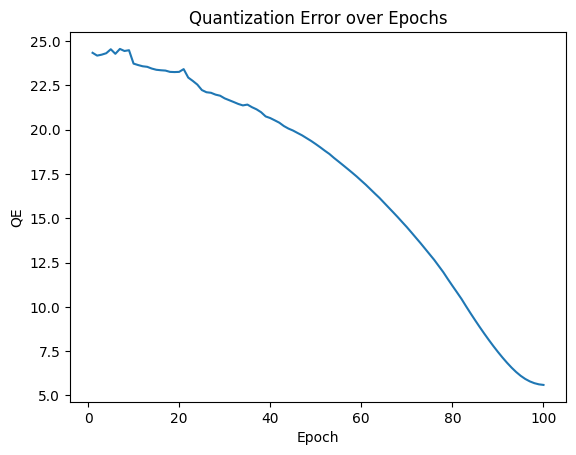

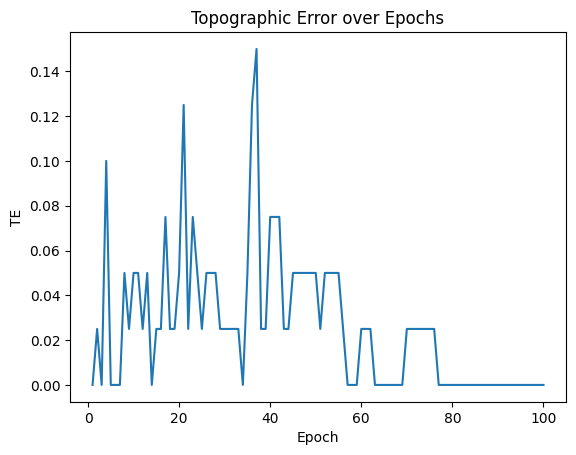

In [80]:
# 3. 绘制 QE / TE 曲线
som_text.plot_errors()

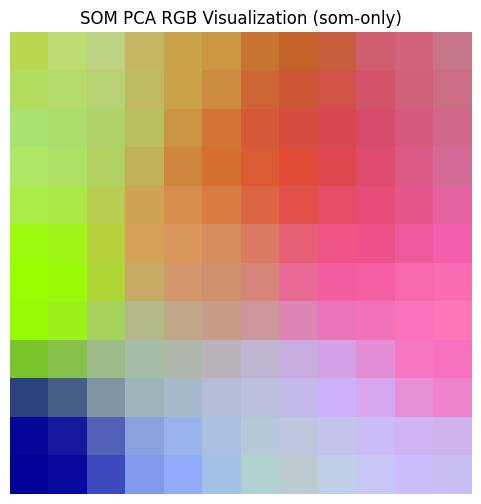

In [81]:
# 使用 SOM-only 模式可视化
plot_som_pca_rgb(som_text, mode="som-only")

#### 对应预览（方便后续查找输入）

In [82]:
# —— 一、加载向量化后的数据集2 —— 
with open("mid2_data/dataset2/vectorized_chunked.json", "r", encoding="utf-8") as f:
    items2 = json.load(f)
texts2 = np.array([it["text_vec"] for it in items2])

# —— 二、预览前10条（标题 + 文本摘要） —— 
def preview_title_text(items, num=3):
    """
    打印前 num 条样本的 标题 + 文本片段
    """
    print(f"预览前 {num} 条标题-文本对：")
    for i, it in enumerate(items[:num], start=1):
        snippet = it["text"].replace("\n", " ")[3000:5000]
        print(f"{i:2d}. 标题: {it['title']}")
        print(f"     文本: {snippet}{'...' if len(it['text'])>3000 else ''}")
        print("-" * 40)

# 调用预览
preview_title_text(items2, num=1)


预览前 1 条标题-文本对：
 1. 标题: The Role of the Residential Environment in Influencing Subjective Well-being
     文本: ntial environment; elderly migrants; China 1. Introduction With the development of high-quality cities in China, the pursuit to improve people’s life and happiness has gradually replaced the simple yearning for wealth. Enhancing people’s subjective well-being (SWB) has become an important goal of the current govern- ment’s livelihood construction. SWB is an important psychological index of individual quality of life, and the term includes affective states, valuations of quality of life of different people, their residential environment, and the events they encounter [1]. The term SWB was ﬁrst introduced by Edward Diener in 1984 as being central to a person’s experience, consist- ing of positive aspects, and a global assessment of a person’s life [2]. In 1995 he modiﬁed this deﬁnition by also including cognitive evaluations or appraisals of life satisfaction as a whole, and emoti

#### 搜索引擎

In [83]:
# 4. 定义搜索函数
def search_by_text2(
    query: str,
    items: list,
    som: SOM,
    scaler: StandardScaler,
    top_k: int = 5,
    max_radius: int = 2
):
    """
    1) 对 query 分块向量化 → 标准化 → 定位 BMU
    2) 在曼哈顿距离 ≤ max_radius 的格点中收集样本
    3) 若无候选，退回全局余弦相似度
    4) 按相似度降序返回 top_k 条 (title, score)
    """
    # 1. 向量化 & 标准化
    q_vec = vectorize_text_chunked(query)
    q_scaled = scaler.transform([q_vec])[0]
    bmu = som.map_vector(q_scaled)

    # 2. BMU 邻域内搜集
    cands = []
    for r in range(max_radius + 1):
        for di in range(-r, r + 1):
            for dj in range(-r, r + 1):
                if abs(di) + abs(dj) > r:
                    continue
                ni, nj = bmu[0] + di, bmu[1] + dj
                if not (0 <= ni < som.m and 0 <= nj < som.n):
                    continue
                for it in items:
                    tv = np.array(it["text_vec"])
                    tv_scaled = scaler.transform([tv])[0]
                    if som.map_vector(tv_scaled) == (ni, nj):
                        sim = cosine_similarity([q_vec], [tv])[0][0]
                        cands.append((it["title"], sim))
        if cands:
            break

    # 3. 全局回退
    if not cands:
        print("⚠️ 无邻域候选，退回全局余弦相似度搜索")
        sims = cosine_similarity(
            [q_vec],
            [np.array(it["text_vec"]) for it in items]
        )[0]
        cands = [(items[i]["title"], sims[i]) for i in range(len(items))]

    # 4. 去重 & 排序 & 返回
    best = {}
    for title, sim in cands:
        if title not in best or sim > best[title]:
            best[title] = sim
    results = sorted(best.items(), key=lambda x: -x[1])[:top_k]
    return results


# 5. 搜索测试示例
query = "Colourdisc Home Fragrances LC17 Portemanteau"
results = search_by_text2(
    query=query,
    items=items2,
    som=som_text,
    scaler=scaler_text,
    top_k=5,
    max_radius=2
)

print("搜索结果（标题, 相似度）：")
for title, score in results:
    print(f"{title} — {score:.4f}")

搜索结果（标题, 相似度）：
The Eyes of the Skin Architecture and the Senses — 0.6373
A Pattern Language Towns, Buildings, Construction — 0.6372


## B.3 家具图片数据集（纯图像）

#### 数据预处理 + 文本向量化

In [84]:
import os
import json
from PIL import Image
from tqdm import tqdm
import torch
from torchvision import models, transforms

# 设定路径
data_dir = "ori_data/Furniture_image_classification"
save_dir = "mid2_data/dataset3"
os.makedirs(save_dir, exist_ok=True)

# 图像预处理（与 ResNet 兼容）
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet均值
                         std=[0.229, 0.224, 0.225])   # ImageNet标准差
])

# 加载预训练模型（去掉分类层）
resnet = models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # 去除最后一层 (fc)
resnet.eval()
resnet.cuda()  

/home/fintuser/fintechlab/dev/condaEnvs/z_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fintuser/fintechlab/dev/condaEnvs/z_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [85]:
dataset = []
with torch.no_grad():
    for class_name in tqdm(os.listdir(data_dir), desc="遍历类别"):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        for img_name in os.listdir(class_path):
            if not img_name.lower().endswith((".jpg", ".png", ".jpeg", ".bmp", ".webp")):
                continue
            img_path = os.path.join(class_path, img_name)
            try:
                image = Image.open(img_path).convert("RGB")
                input_tensor = preprocess(image).unsqueeze(0).cuda()  # [1, 3, 224, 224]
                feature = resnet(input_tensor).squeeze().cpu().numpy()  # [512]
                
                dataset.append({
                    "image_path": img_path,
                    "label": class_name,
                    "img_vec": feature.tolist()
                })
            except Exception as e:
                print(f"跳过损坏图像: {img_path}，错误: {e}")


遍历类别: 100%|██████████| 220/220 [00:33<00:00,  6.54it/s]


In [86]:
with open(os.path.join(save_dir, "vectorized.json"), "w", encoding="utf-8") as f:
    json.dump(dataset, f, indent=2, ensure_ascii=False)

print(f"共处理图像数：{len(dataset)}")

共处理图像数：792


#### SOM实现

In [87]:
import os
import json
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# —— 复用之前的 SOM 类 —— 
class SOM:
    def __init__(self, m, n, dim, num_iterations=100, alpha0=0.5, sigma0=None):
        self.m, self.n, self.dim = m, n, dim
        self.num_iterations = num_iterations
        self.alpha0 = alpha0
        self.sigma0 = sigma0 or max(m,n)/2.0
        self.weights = np.random.randn(m, n, dim)

        self.qe_history = []
        self.te_history = []
        self.error_epochs = []
        self.error_interval = max(1, num_iterations // 10)

    def _decay(self, t):
        alpha = self.alpha0 * (1 - t / self.num_iterations)
        sigma = self.sigma0 * (1 - t / self.num_iterations)
        return alpha, sigma

    def _find_bmu(self, x):
        dists = np.linalg.norm(self.weights - x.reshape(1,1,-1), axis=2)
        return np.unravel_index(np.argmin(dists), (self.m, self.n))

    def quantization_error(self, data):
        wf = self.weights.reshape(-1, self.dim)
        d = np.linalg.norm(data[:,None,:] - wf[None,:,:], axis=2)
        return float(np.mean(np.min(d, axis=1)))

    def topographic_error(self, data):
        wf = self.weights.reshape(-1, self.dim)
        d = np.linalg.norm(data[:,None,:] - wf[None,:,:], axis=2)
        idx = np.argpartition(d, 2, axis=1)[:, :2]
        coords = np.array([divmod(i, self.n) for i in range(self.m*self.n)])
        b1 = coords[idx[:,0]]; b2 = coords[idx[:,1]]
        manh = np.abs(b1 - b2).sum(axis=1)
        return float(np.mean(manh > 1))

    def train(self, data):
        for t in range(self.num_iterations):
            alpha, sigma = self._decay(t)
            for x in data:
                i_bmu, j_bmu = self._find_bmu(x)
                for i in range(self.m):
                    for j in range(self.n):
                        dist_grid = abs(i - i_bmu) + abs(j - j_bmu)
                        h = np.exp(- dist_grid**2 / (2 * sigma**2))
                        self.weights[i,j] += alpha * h * (x - self.weights[i,j])

            if t % self.error_interval == 0 or t == self.num_iterations-1:
                self.error_epochs.append(t+1)
                self.qe_history.append(self.quantization_error(data))
                self.te_history.append(self.topographic_error(data))
        print(f"SOM trained: {self.m}×{self.n}, {self.num_iterations} iter")

    def plot_errors(self):
        plt.figure()
        plt.plot(self.error_epochs, self.qe_history)
        plt.title("Quantization Error over Epochs")
        plt.xlabel("Epoch"); plt.ylabel("QE")
        plt.xticks(self.error_epochs)
        plt.show()

        plt.figure()
        plt.plot(self.error_epochs, self.te_history)
        plt.title("Topographic Error over Epochs")
        plt.xlabel("Epoch"); plt.ylabel("TE")
        plt.xticks(self.error_epochs)
        plt.show()

    def map_data(self, data):
        return np.array([self._find_bmu(x) for x in data])
        
    def map_vector(self, x):
        """将单个向量 x 映射到 BMU 网格坐标"""
        return self._find_bmu(x)

# —— 辅助函数 —— 
def load_vectorized3(path="mid2_data/dataset3/vectorized.json"):
    """
    加载 vectorized.json，返回:
      - items: 原始列表，每项含 image_path, label, img_vec
      - vecs:   numpy 数组 (N, dim)
      - labels: 对应的标签列表
      - paths:  对应的图片路径列表
    """
    with open(path, "r", encoding="utf-8") as f:
        items = json.load(f)
    vecs   = np.vstack([it["img_vec"] for it in items])
    labels = [it["label"]   for it in items]
    paths  = [it["image_path"] for it in items]
    return items, vecs, labels, paths

def train_som_on(vecs, som_dim=(10,10), iterations=100):
    """
    对 vecs 做 StandardScaler，再训练 SOM，返回 (som, scaler)
    """
    scaler = StandardScaler()
    vs = scaler.fit_transform(vecs)
    som = SOM(som_dim[0], som_dim[1], vs.shape[1], num_iterations=iterations)
    som.train(vs)
    return som, scaler


In [88]:
# 1. 加载数据
items3, img_vecs, labels3, paths3 = load_vectorized3()

In [89]:
# 2. 训练 SOM（可调 m,n,iterations）
som_img, scaler_img = train_som_on(img_vecs, som_dim=(12,12), iterations=100)

SOM trained: 12×12, 100 iter


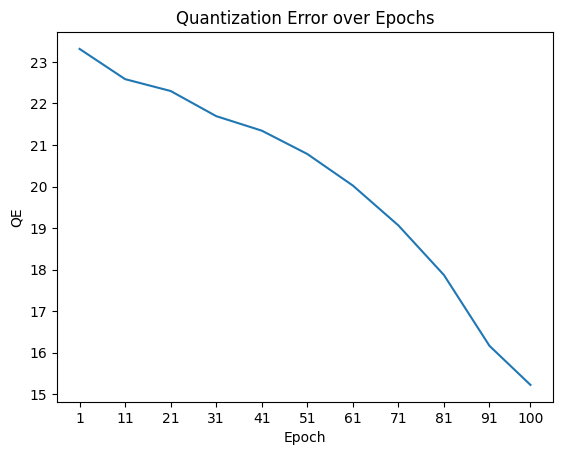

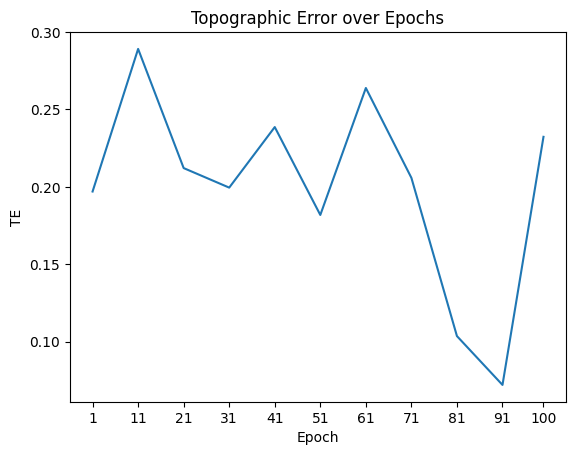

In [90]:
# 3. 绘制 QE/TE 曲线，帮助选模型
som_img.plot_errors()

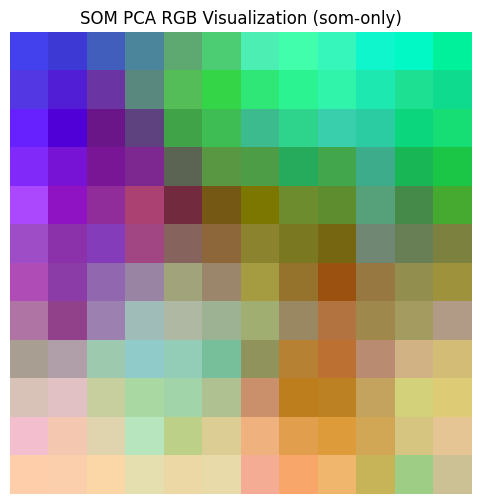

In [91]:
# 使用 SOM-only 模式可视化
plot_som_pca_rgb(som_img, mode="som-only")

In [92]:
# 4. 映射所有图像到 BMU 并统计
bmus = som_img.map_data(scaler_img.transform(img_vecs))
# 统计每个格点上的样本数
from collections import Counter
cnt = Counter([tuple(b) for b in bmus])
print("BMU 分布（只列出前 10 个最密集的节点）：")
for bmu, c in cnt.most_common(10):
    print(f"  网格 {bmu}: {c} 张图像")

BMU 分布（只列出前 10 个最密集的节点）：
  网格 (np.int64(11), np.int64(5)): 16 张图像
  网格 (np.int64(9), np.int64(10)): 15 张图像
  网格 (np.int64(11), np.int64(2)): 14 张图像
  网格 (np.int64(1), np.int64(4)): 14 张图像
  网格 (np.int64(11), np.int64(0)): 14 张图像
  网格 (np.int64(9), np.int64(11)): 13 张图像
  网格 (np.int64(7), np.int64(4)): 13 张图像
  网格 (np.int64(11), np.int64(7)): 13 张图像
  网格 (np.int64(1), np.int64(7)): 12 张图像
  网格 (np.int64(10), np.int64(11)): 11 张图像


#### 搜索引擎

In [97]:
import numpy as np
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity

# 1. 预先计算训练集所有样本的 BMU
#    注意：这里传入的是标准化后的向量
vs = scaler_img.transform(img_vecs)          # (N, dim)
train_bmus = som_img.map_data(vs)            # shape (N, 2)

# 2. 预测函数（使用 _find_bmu）
def predict_label(
    image_path: str,
    som: SOM,
    scaler: StandardScaler,
    img_vecs: np.ndarray,
    labels: list,
    train_bmus: np.ndarray,
    max_radius: int = 2
) -> str:
    """
    输入一张图像，输出预测标签（子文件夹名）。
    直接在这里把图像转成向量，不再依赖其它函数。
    """
    # 0. 导入所需
    from PIL import Image
    import torch

    # 1. 向量化：用预处理管道 + ResNet 提取 512 维特征
    img = Image.open(image_path).convert("RGB")
    x = preprocess(img).unsqueeze(0).cuda()      # [1,3,224,224]
    with torch.no_grad():
        vec = resnet(x).squeeze().cpu().numpy()  # (512,)

    # 2. 标准化
    vec_scaled = scaler.transform([vec])[0]

    # 3. 找 BMU
    bmu = som._find_bmu(vec_scaled)

    # 4. 半径内投票
    candidates = []
    for r in range(max_radius + 1):
        for di in range(-r, r+1):
            for dj in range(-r, r+1):
                if abs(di) + abs(dj) > r:
                    continue
                ni, nj = bmu[0] + di, bmu[1] + dj
                if 0 <= ni < som.m and 0 <= nj < som.n:
                    idxs = np.where((train_bmus == (ni, nj)).all(axis=1))[0]
                    for idx in idxs:
                        candidates.append(labels[idx])
        if candidates:
            break

    # 5. 回退全局最近邻
    if not candidates:
        sims = cosine_similarity([vec], img_vecs)[0]
        return labels[int(np.argmax(sims))]

    # 6. 多数投票
    return Counter(candidates).most_common(1)[0][0]

# 3. 使用示例
test_image = "ori_data/Furniture_image_classification/SARPI TABLE - Esstische von Cassina Architonic/0_cassina-simoncollezione-sarpi-office-carlo-scarpa-b.jpg"
predicted = predict_label(
    test_image,
    som_img,
    scaler_img,
    img_vecs,
    labels3,
    train_bmus,
    max_radius=2
)
print(f"图像 {test_image.split('/')[-1]} 预测标签：{predicted}")


图像 0_cassina-simoncollezione-sarpi-office-carlo-scarpa-b.jpg 预测标签：833 CAVALLETTO - Dining tables from Cassina Architonic
